## Setup and Import Libraries

In [ ]:
import os
import bs4
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.agents import tool
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-5")

## Document Ingestion and Processing

In [5]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

In [6]:
documents = loader.load()
documents

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
)

In [8]:
chunks = text_splitter.split_documents(documents=documents)
chunks

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

## Creating Vector Store

In [9]:
vector_store = FAISS.from_documents(
    documents=chunks,
    embedding=embeddings
)

print(f"Vector store created with {vector_store.index.ntotal} vectors")

Vector store created with 63 vectors


## Creating Tool

In [10]:
@tool()
def retrieve(query:str):
    """
    Retrieve the information related to the query
    """
    retrieved_documents = vector_store.similarity_search(query, k=2)
    serialized_document = "\n\n".join(
        (f"Source: {retrieved_document.metadata}\nContent: {retrieved_document.page_content}")
        for retrieved_document in retrieved_documents
    )
    return serialized_document, retrieved_documents

## Creating Nodes

In [11]:
def query_or_respond(state: MessagesState):
    """
    Generate tool call for retrieval or respond.
    """
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [12]:
tools = ToolNode([retrieve])

In [13]:
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    document_content = "\n\n".join(message.content for message in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{document_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

## Building Graph

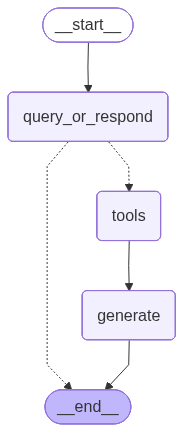

In [14]:
graph_builder = StateGraph(MessagesState)

# Adding Nodes
graph_builder.add_node(node="query_or_respond", action=query_or_respond)
graph_builder.add_node(node="tools",action=tools)
graph_builder.add_node(node="generate", action=generate)

# Set Entry Point
graph_builder.set_entry_point(key="query_or_respond")

# Adding Edges
graph_builder.add_conditional_edges(
    source="query_or_respond",
    path=tools_condition,
    path_map={
        END: END, 
        "tools": "tools"
    },
)
graph_builder.add_edge(start_key="tools", end_key="generate")
graph_builder.add_edge(start_key="generate", end_key=END)

# Adding Memory
memory = MemorySaver()

# Compiling Graph
graph = graph_builder.compile(checkpointer=memory)

graph

In [15]:
config = {"configurable": {"thread_id": "thread1"}}

In [16]:
input_message="Hello"

for step in graph.stream(
    input={"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hi there! How can I help you today?


In [17]:
vector_store.similarity_search("What is Task Decomposition")

[Document(id='9524f157-b244-4c5d-9f45-885758e1e168', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-f

In [18]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    input={"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the practice of breaking a complex goal into smaller, clearly defined sub-tasks that are easier to understand, estimate, execute, and verify. Each sub-task has a specific outcome, owner, and dependencies, and together they reconstruct the original goal.

Why it’s useful
- Reduces cognitive load and ambiguity
- Improves estimates and scheduling
- Enables parallel work and automation
- Isolates errors and simplifies testing
- Makes progress measurable

How to do it (quick method)
1) Define the desired outcome and constraints.
2) Identify major phases (milestones).
3) Break each phase into atomic tasks (short, testable).
4) Specify “done” criteria for each task.
5) Map dependencies and order the tasks.
6) Estimate, assign, and iterate as you learn.

Common techniques
- Hierarchi

In [19]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    input={"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Pcbj34qClfiXzvVxXccfl4FI)
 Call ID: call_Pcbj34qClfiXzvVxXccfl4FI
  Args:
    query: common methods of task decomposition WBS HTA MECE Hierarchical Task Network planning story mapping user story slicing functional decomposition divide and conquer sources
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step

## Checking Conversation History

In [20]:
chat_history = graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hi there! How can I help you today?
================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the practice of breaking a complex goal into smaller, clearly defined sub-tasks that are easier to understand, estimate, execute, and verify. Each sub-task has a specific outcome, owner, and dependencies, and together they reconstruct the original goal.

Why it’s useful
- Reduces cognitive load and ambiguity
- Improves estimates and scheduling
- Enables parallel work and automation
- Isolates errors and simplifies testing
- Makes progress measurable

How to do it (quick method)
1) Define the desired outcome and constraints.
2) Identify major phases (milestones).
3) Break ea